# Project: Us Air Quality
## Table of Contents

<ul>
<li><a href= '#Intro'>Introduction</a></li>
<li><a href= '#Data Wrangling'>Data Wrangling</a></li>
<li><a href= '#EDA'>Exploratory Data Analysis</a></li>
<li><a href= '#ML ML'>Machine Learning Preprocessing, Modeling And Deployment</a></li>
<li><a href= '#Conclusion'>Conclusion</a></li>
</ul>

<a id= 'Intro'></a>
## Introduction

### Data Description

>AQI or Air Quality Index is the primary way to measure the current quality of the air. AQI values range from 0-500 with 0 being perfectly healthy and 500 being extremally hazardous. AQI values are derived from moving averages/current values of PM2.5 (particulate matter), PM10, Ozone, Carbon Monoxide, Sulfur Dioxide, and Nitrogen Dioxide levels.

### Dataset Difination

>**CBSA Code** => The core-based statistical area (CBSA) code. CBSA = a U.S. geographic area defined by the Office of Management and Budget (OMB) that consists of one or more counties.

>**Date** => The day of measurement.

>**AQI** => The average air quality index (AQI) value for the day.

>**Category** => The category of air quality ranging from "Good" to "Hazardous".

>**Defining Parameter** => One of PM2.5 (particulate matter), PM10, Ozone, Carbon Monoxide, Sulfur Dioxide, or Nitrogen Dioxide which has the highest concentration.

>**Number of Sites Reporting** => The number of stations used to make the data aggregation.

>**city_ascii** => Name of the city where the measurement was taken.

>**state_id** => Abbreviation of the state where the measurement was taken.

>**state_name** => The state where the measurement was taken.

>**lat** => The latitude where the measurement was taken.

>**lng** => The longitude where the measurement was taken.

>**population** => The population of the region where the measurement was taken.

>**density** => The population per square kilometer where the measurement was taken.

>**timezone** => The time zone of the region where the measurement was taken.

### Question(s) to Analysis

> What's the average of AQI for last 10 year in California for each City ?

> What's the highest parameter concentration along months in California ?

> compare between Riverside city and Los Angeles city which one have better AQI ?

> Does the area of the city in square kilometers affect on the Number of Sites Reporting needed to measure AQI (in California) ?

> what's the reason behind the increasing in number of testing in last decade ?

### Import libraries

In [ ]:
# Install important library
!pip install empiricaldist
!pip install pyngrok
!pip install streamlit

In [1]:
# libraries for data wrangling and visualization
import os
import joblib
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(rc = {'figure.figsize' : [23,9]})
import missingno as msno
from empiricaldist import Pmf, Cdf

# libraries for preprocessing, pipeline and hyperparameter tuning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import train_test_split, KFold, HalvingGridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight

# libraries for classification and regression model
import xgboost as xgb
from xgboost import XGBRFRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, mean_absolute_error, r2_score
from yellowbrick.classifier import ROCAUC
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from pyngrok import ngrok

<a id = 'Data Wrangling'></a>
## Data Wrangling

### Load, Explore and Clean

In [3]:
# access google drive
drive.mount('/content/Gdrive') # => do not run this line if you not access your google drive
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/Gdrive/MyDrive/kaggle_dataset/Us Air Quality' # => important line to connect google drive with kaggle

Mounted at /content/Gdrive


In [2]:
# change dir to project folder
# => if you run this notebook on your google colab please ignore this cell or change dir to your dir
%cd /content/Gdrive/MyDrive/kaggle_dataset/Us Air Quality

/content/Gdrive/MyDrive/kaggle_dataset/Us Air Quality


In [ ]:
# download dataset from kaggle
# !kaggle datasets download -d calebreigada/us-air-quality-1980present

In [ ]:
# unzip file downloaded
#!unzip us-air-quality-1980present.zip

In [3]:
# load csv file
df = pd.read_csv('US_AQI.csv')

In [ ]:
# dataframe shape
df.shape

(5617325, 15)

In [ ]:
# explore
df.head()

,Unnamed: 0,CBSA Code,Date,AQI,Category,Defining Parameter,Number of Sites Reporting,city_ascii,state_id,state_name,lat,lng,population,density,timezone
0,0,10140,2022-01-01,21,Good,PM2.5,2,Aberdeen,WA,Washington,46.9757,-123.8094,16571.0,588.0,America/Los_Angeles
1,1,10140,2022-01-02,12,Good,PM2.5,2,Aberdeen,WA,Washington,46.9757,-123.8094,16571.0,588.0,America/Los_Angeles
2,2,10140,2022-01-03,18,Good,PM2.5,2,Aberdeen,WA,Washington,46.9757,-123.8094,16571.0,588.0,America/Los_Angeles
3,3,10140,2022-01-04,19,Good,PM2.5,2,Aberdeen,WA,Washington,46.9757,-123.8094,16571.0,588.0,America/Los_Angeles
4,4,10140,2022-01-05,17,Good,PM2.5,2,Aberdeen,WA,Washington,46.9757,-123.8094,16571.0,588.0,America/Los_Angeles


In [4]:
# sort value on date
df.sort_values('Date' ,inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# get information
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5617325 entries, 0 to 5617324
Data columns (total 15 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Unnamed: 0                 5617325 non-null  int64  
 1   CBSA Code                  5617325 non-null  int64  
 2   Date                       5617325 non-null  object 
 3   AQI                        5617325 non-null  int64  
 4   Category                   5617325 non-null  object 
 5   Defining Parameter         5617325 non-null  object 
 6   Number of Sites Reporting  5617325 non-null  int64  
 7   city_ascii                 5617325 non-null  object 
 8   state_id                   5617325 non-null  object 
 9   state_name                 5617325 non-null  object 
 10  lat                        5617325 non-null  float64
 11  lng                        5617325 non-null  float64
 12  population                 5617325 non-null  float64
 13  density     

In [5]:
# remove unnamed column and state_id
df.drop(['Unnamed: 0','state_id'], axis=1, inplace=True)

In [ ]:
# check duplicates row
df.duplicated().sum()

0

In [ ]:
# df describe
df.describe()

,CBSA Code,AQI,Number of Sites Reporting,lat,lng,population,density
count,5.617325e+06,5.617325e+06,5.617325e+06,5.617325e+06,5.617325e+06,5.617325e+06,5.617325e+06
mean,3.028285e+04,4.665572e+01,3.650273e+00,3.849210e+01,-9.425695e+01,5.642292e+05,1.083637e+03
std,1.142715e+04,3.570811e+01,5.092484e+00,5.595372e+00,1.678664e+01,1.537382e+06,1.013632e+03
min,1.010000e+04,0.000000e+00,1.000000e+00,1.797430e+01,-1.593521e+02,1.903000e+03,4.000000e+00
25%,2.010000e+04,3.000000e+01,1.000000e+00,3.494420e+01,-1.069642e+02,2.843700e+04,5.250000e+02
50%,3.034000e+04,4.100000e+01,2.000000e+00,3.918860e+01,-8.893420e+01,1.225490e+05,8.340000e+02
75%,4.042000e+04,5.400000e+01,4.000000e+00,4.211550e+01,-8.154200e+01,3.913710e+05,1.255000e+03
max,4.974000e+04,2.064600e+04,7.200000e+01,6.483530e+01,-6.606100e+01,1.868002e+07,1.076800e+04


### Feature Extract & Transform

In [6]:
# convert date to datetime
df.Date = pd.to_datetime(df.Date)

In [7]:
# extract year from date
df.insert(2,'Year', df.Date.dt.year)

In [8]:
# extract month from date
df.insert(3,'Month', df.Date.dt.month)

In [9]:
# extract day from date
df.insert(4,'Day', df.Date.dt.day)

In [10]:
# extract square kilometer where the measurement was taken
df.insert(15, 'sq_kilometer (km2)', df['population'] / df['density'])

<a id = 'EDA'></a>
## Exploratory Data Analysis

### Univariate Analysis

In [36]:
# no. of unique values of CBSA Code
df['CBSA Code'].nunique()

671

> CBSA Code abbreviation for core-based statistical area.

> there is two area for CBSA Code (Metropolitan Area, Micropolitan Area).

In [11]:
# Labels function
def labels(Title, Xlabel=None, Ylabel=None, Rotation= None):
  """
  This function return title, xlabel, ylabel and rotation of xticks
  """
  plt.title(Title, fontsize= 22)
  plt.xlabel(Xlabel, fontsize= 18)
  plt.ylabel(Ylabel, fontsize= 18)
  plt.xticks(rotation= Rotation);

In [ ]:
# unique value of Year
df.Year.unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

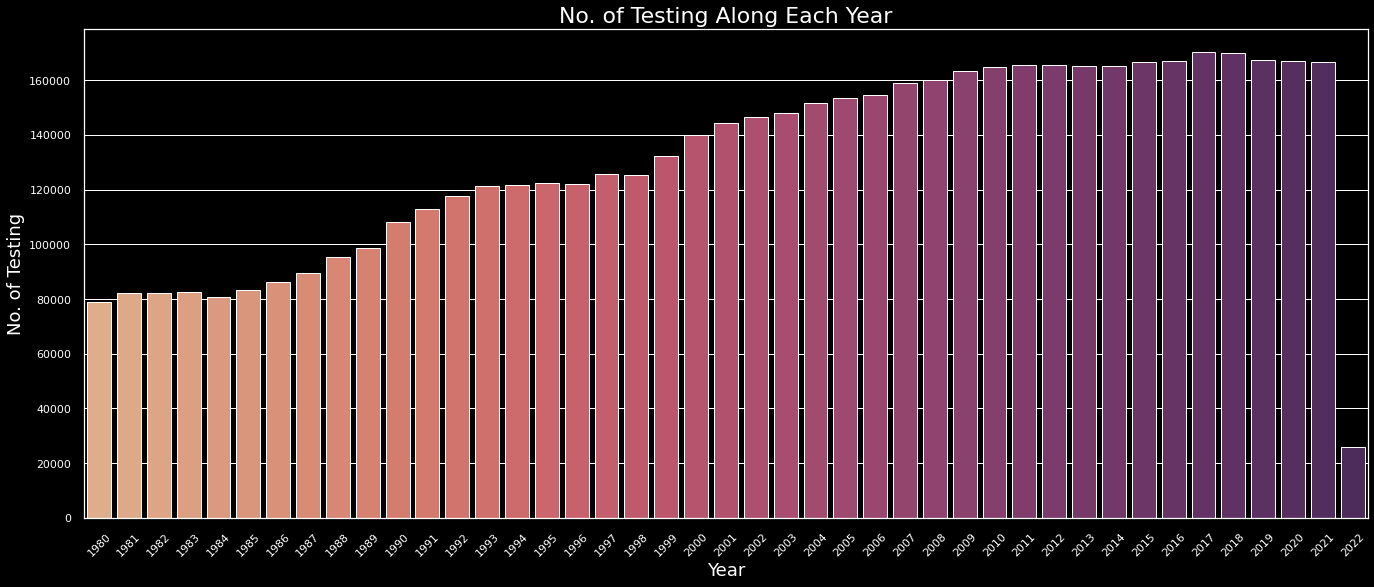

In [ ]:
# no. of testing along each year
plt.style.use('dark_background')
sns.countplot(x=df.Year, palette='flare')
labels('No. of Testing Along Each Year', 'Year', 'No. of Testing', 45)

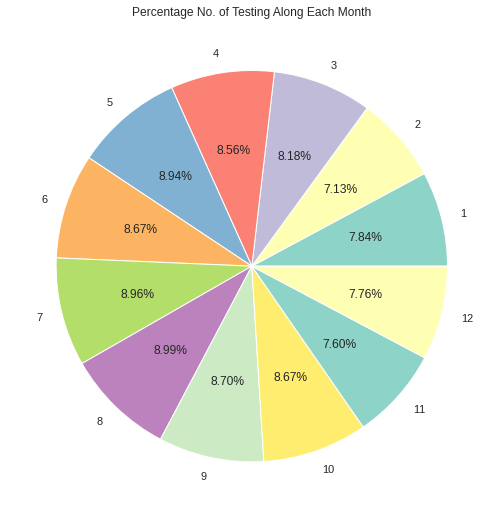

In [ ]:
# Percentage No. of Testing Along Each Month
months = df.Month.value_counts().sort_index()
plt.style.use('seaborn-white')
plt.pie(months.values, labels=months.index, autopct='%.2f%%')
plt.title('Percentage No. of Testing Along Each Month');

> The air quality index (AQI) is an index for reporting air quality on a daily basis. It is a measure of how air pollution affects one's health within a short time period. The purpose of the AQI is to help people know how the local air quality impacts their health. The Environmental Protection Agency (EPA) calculates the AQI for five major air pollutants, for which national air quality standards have been established to safeguard public health.

---

> for AQI between (0 : 50) use description (Good with color Green)

> for AQI between (51 : 100) use description (Moderate with color Yellow)

> for AQI between (101 : 150) use description (Unhealthy for Sensitive Groups with color Orange)

> for AQI between (151 : 200) use description (Unhealthy with color Red)

> for AQI between (201 : 300) use description (Very Unhealthy with color Purple)

> for AQI between (301 : 500) use description (Hazardous with color Maroon)

In [ ]:
# value counts
df['AQI'].value_counts()

44      191378
31      174602
38      142144
40      131074
35      127886
         ...  
449          1
995          1
867          1
1400         1
733          1
Name: AQI, Length: 774, dtype: int64

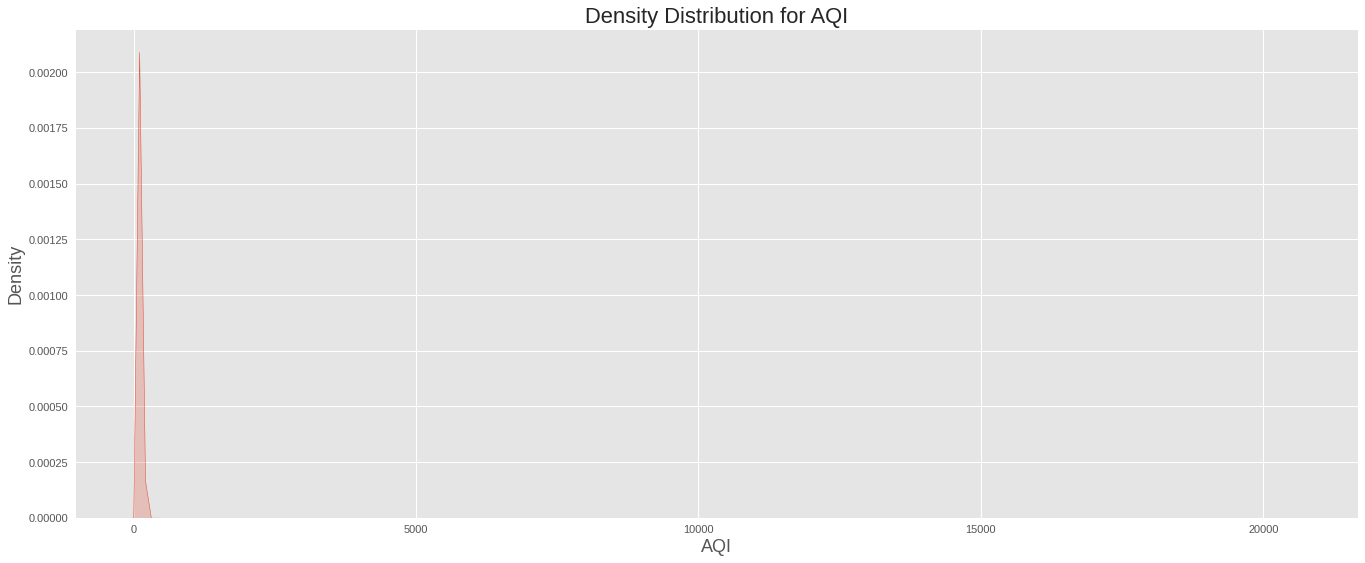

In [ ]:
# KDE plot of AQI
plt.style.use('ggplot')
sns.kdeplot(data=df, x='AQI', shade= True)
labels('Density Distribution for AQI', 'AQI', 'Density')

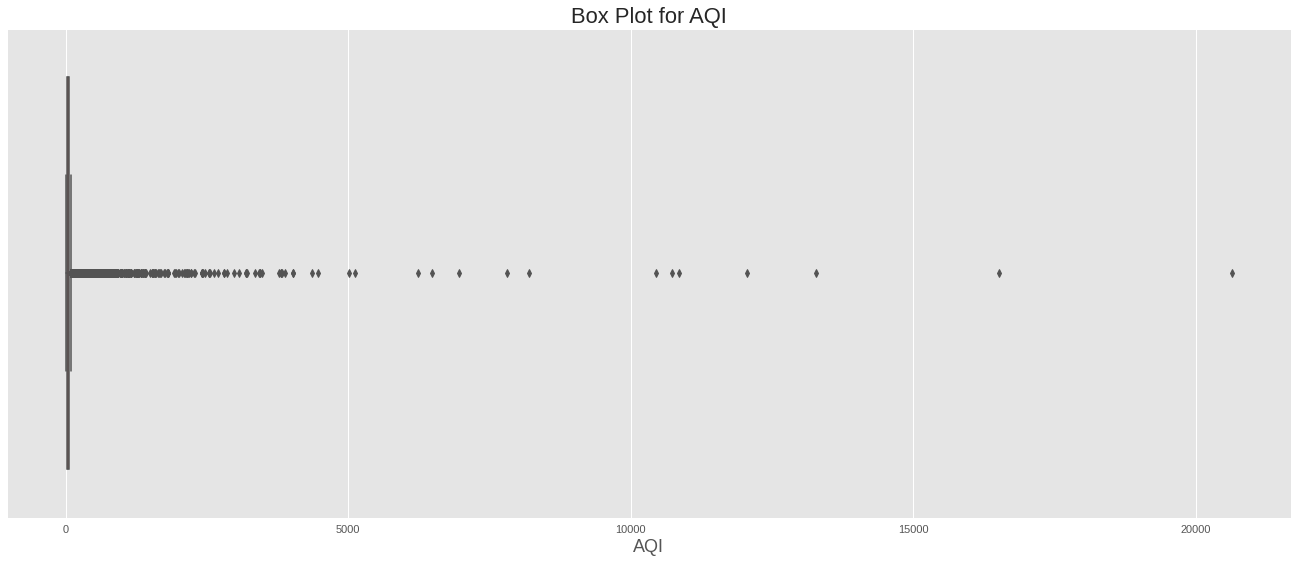

In [ ]:
# boxplot of AQI
sns.boxplot(data=df, x='AQI')
labels('Box Plot for AQI', 'AQI')

In [ ]:
# number of outlier in AQI
df[df['AQI'] > 500].shape[0]

409

In [12]:
# drop outlier in AQI
df.drop(df[df['AQI'] > 500].index, inplace=True)

In [ ]:
# value counts
df['Category'].value_counts()

Good                              3939742
Moderate                          1375385
Unhealthy for Sensitive Groups     219344
Unhealthy                           65035
Very Unhealthy                      16939
Hazardous                             471
Name: Category, dtype: int64

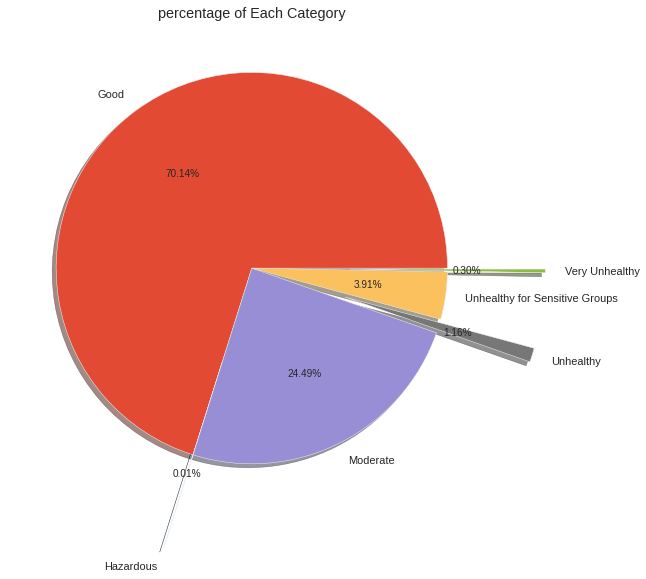

In [ ]:
# percentage of each category
category = df['Category'].value_counts().sort_index()
plt.pie(category.values, labels= category.index, autopct='%.2f%%', explode=[0,.5,0,.5,0,.5], shadow=True)
plt.title('percentage of Each Category');

In [ ]:
# pmf of parameter
pmf = Pmf.from_seq(df['Defining Parameter'])
pmf

,probs
CO,0.060399
NO2,0.063944
Ozone,0.539393
PM10,0.082427
PM2.5,0.253838


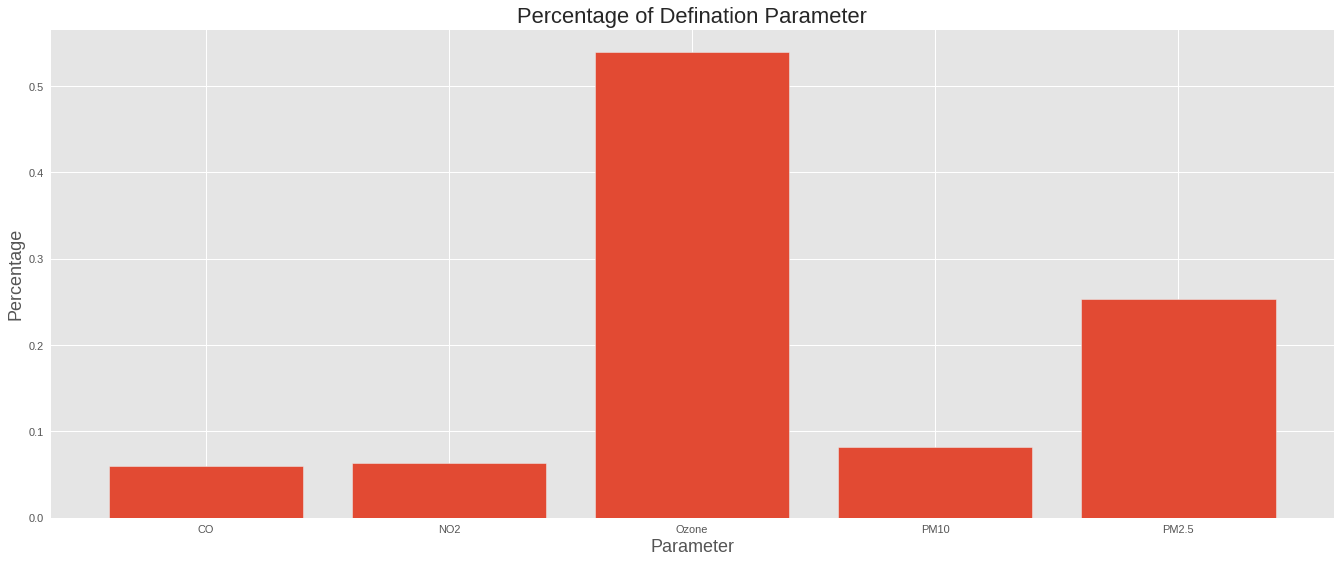

In [ ]:
# percentage of defination parameter
plt.style.use('ggplot')
plt.bar(pmf.index, pmf.values)
labels('Percentage of Defination Parameter', 'Parameter', 'Percentage')

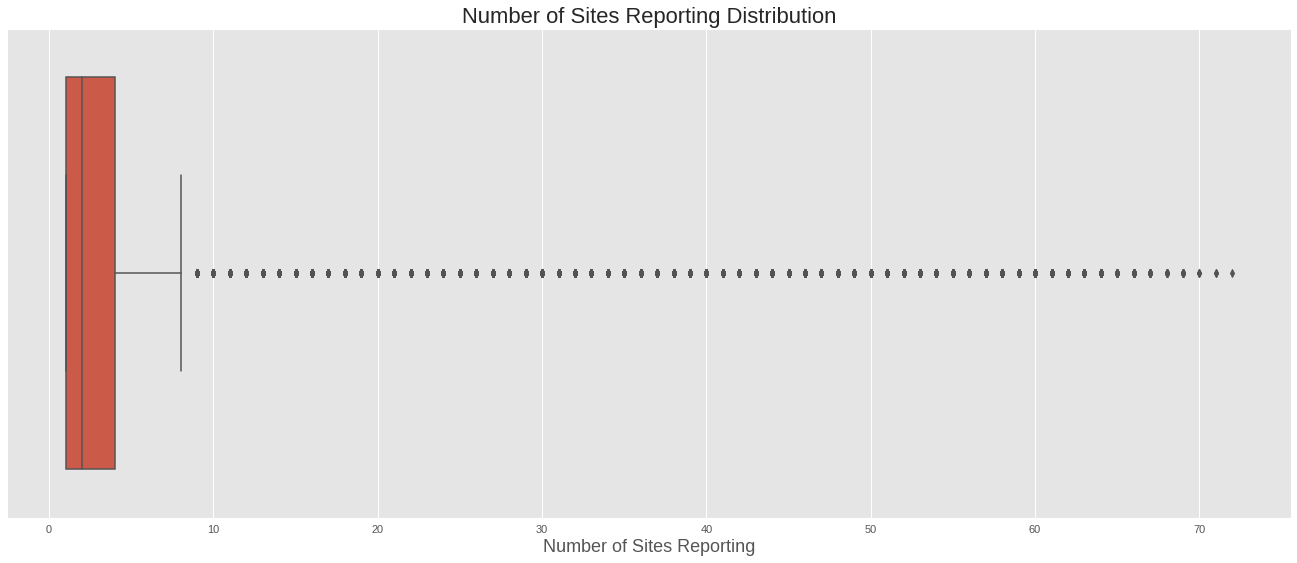

In [ ]:
# box plot for Number of Sites Reporting
sns.boxplot(x= df['Number of Sites Reporting'])
labels('Number of Sites Reporting Distribution', 'Number of Sites Reporting')

In [ ]:
# no. of testing taken in each city
cities_count = df['city_ascii'].value_counts()
cities_count

Springfield    57683
Columbus       34200
Cleveland      32840
Jackson        32515
Charleston     31065
               ...  
Sandusky          60
Hutchinson        53
Celina            47
Newport           33
Maysville         19
Name: city_ascii, Length: 614, dtype: int64

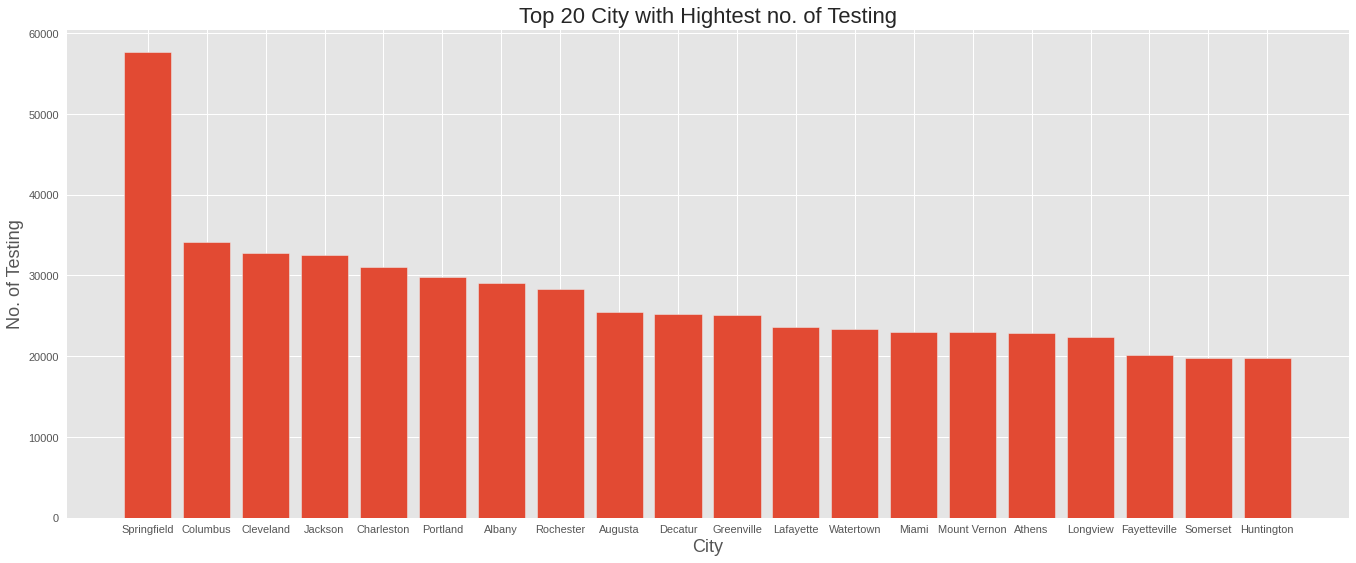

In [ ]:
# top 20 city with hightest no. of testing
plt.bar(cities_count.index[0:20], cities_count.values[0:20])
labels('Top 20 City with Hightest no. of Testing', 'City', 'No. of Testing')

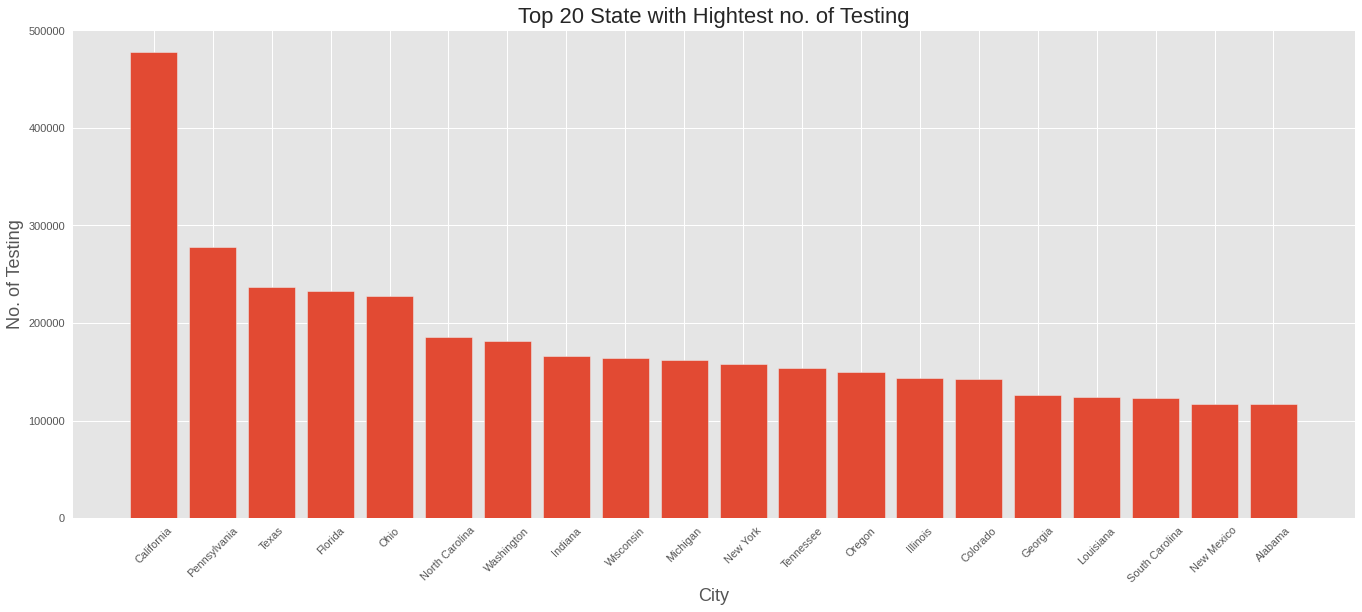

In [ ]:
# top 20 state with hightest no. of testing
plt.bar(df['state_name'].value_counts().index[0:20], df['state_name'].value_counts().values[0:20])
labels('Top 20 State with Hightest no. of Testing', 'City', 'No. of Testing', 45)

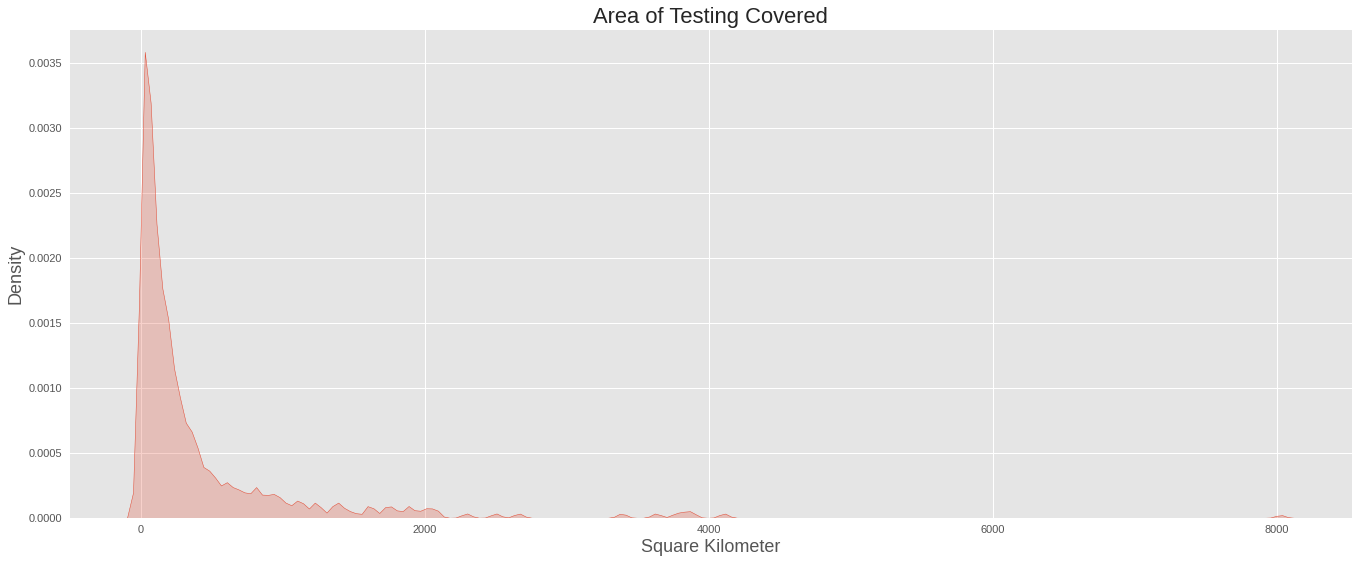

In [ ]:
# denisty of areas that the testing covered
sns.kdeplot(x= df['sq_kilometer (km2)'], shade=True)
labels('Area of Testing Covered', 'Square Kilometer', 'Density')

In [ ]:
# timezone value counts
df['timezone'].value_counts()

America/New_York                2018715
America/Chicago                 1575554
America/Los_Angeles              925818
America/Denver                   544523
America/Detroit                  155617
America/Indiana/Indianapolis     125859
America/Phoenix                  105991
America/Boise                     33162
America/Puerto_Rico               27934
America/Anchorage                 27246
Pacific/Honolulu                  25617
America/Indiana/Vincennes         17051
America/Matamoros                 16056
America/Juneau                    10058
America/Menominee                  6460
America/Toronto                     889
America/Sitka                       366
Name: timezone, dtype: int64

In [ ]:
# no. of different timezone
df['timezone'].nunique()

17

### Question to Analysis (Bivariate & Multivariate Analysis)

#### What's the average of AQI for last 10 year in California for each City ?

In [ ]:
#filter
filter = (df['state_name'] == 'California') & (df['Year'] >= 2012) & (df['Year'] < 2022)
California = df[filter]

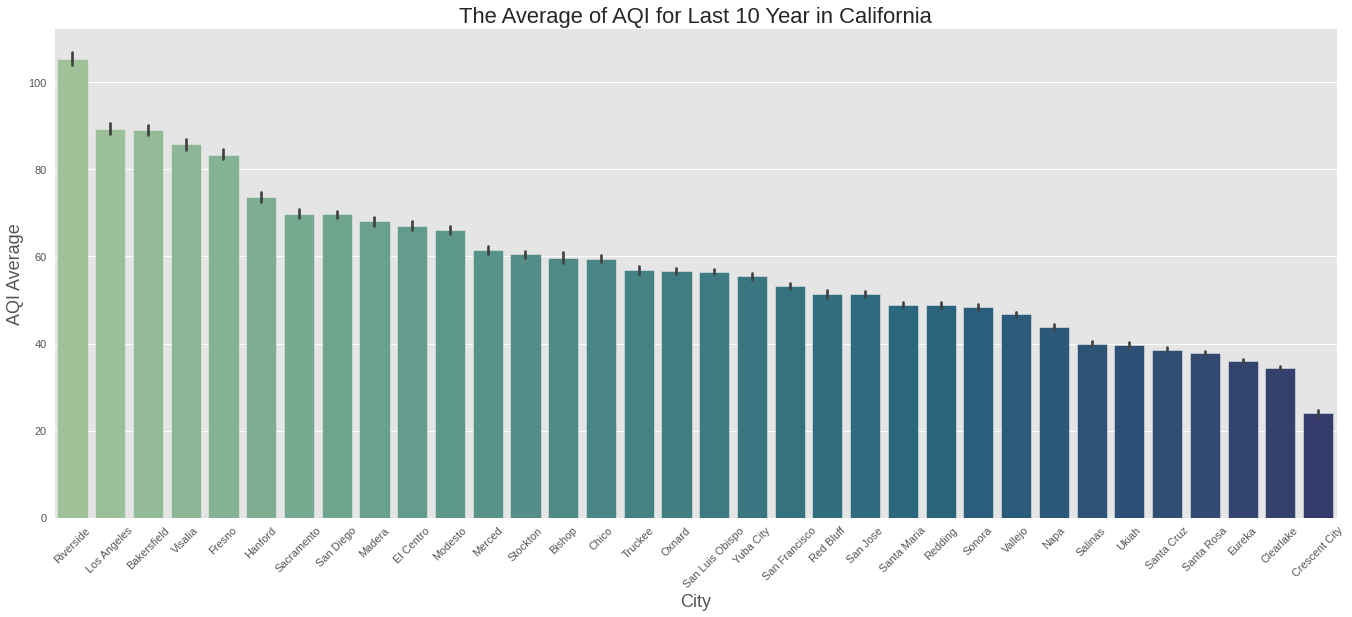

In [ ]:
# plot
order = California.groupby('city_ascii').mean().sort_values('AQI', ascending=False).index
fig1 = sns.barplot(data=California, x= 'city_ascii', y= 'AQI', order=order, palette='crest')
labels("The Average of AQI for Last 10 Year in California", 'City', 'AQI Average', 45)
plt.savefig('EDA/Q1.png', facecolor=fig1.get_facecolor(), edgecolor='none', dpi=150)

#### What's the highest parameter concentration along months in California ?

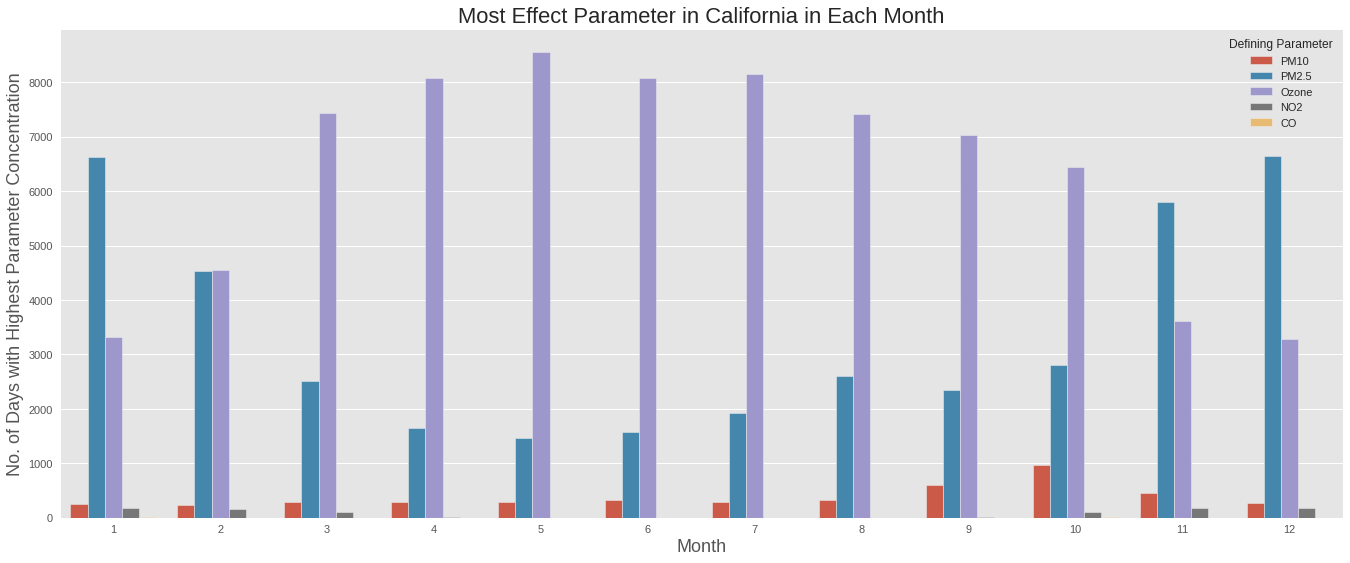

In [ ]:
# plot
fig2 = sns.countplot(data=California, x='Month', hue='Defining Parameter')
labels('Most Effect Parameter in California in Each Month', 'Month', 'No. of Days with Highest Parameter Concentration')
plt.savefig('EDA/Q2.png', facecolor=fig2.get_facecolor(), edgecolor='none', dpi=150)

#### compare between Riverside city and Los Angeles city which one have better AQI ?

In [ ]:
# filter
riverside = California['city_ascii'] == 'Riverside'
los_angeles = California['city_ascii'] == 'Los Angeles'

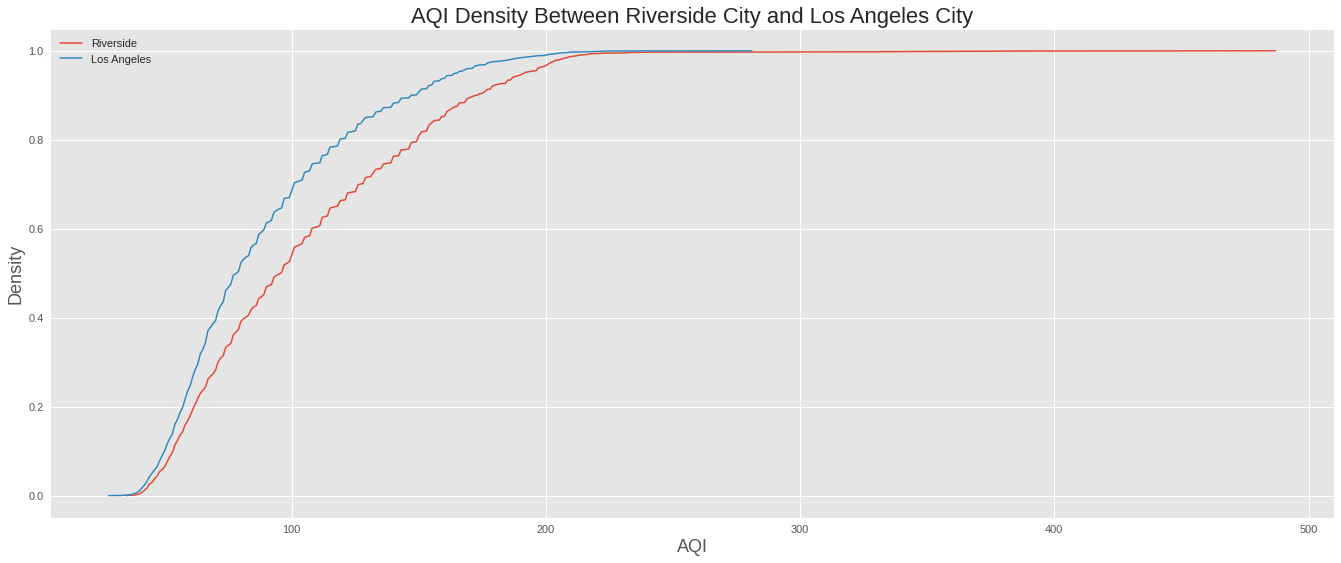

In [ ]:
# plot
plt.plot(Cdf.from_seq(California[riverside].AQI), label='Riverside')
plt.plot(Cdf.from_seq(California[los_angeles].AQI), label= 'Los Angeles')
plt.legend()
labels('AQI Density Between Riverside City and Los Angeles City', 'AQI', 'Density')
plt.savefig('EDA/Q3.png', facecolor=(0.8980392156862745, 0.8980392156862745, 0.8980392156862745, 1.0), edgecolor='none', dpi=150)

#### Does the area of the city in square kilometers affect on the Number of Sites Reporting needed to measure AQI (in California) ?

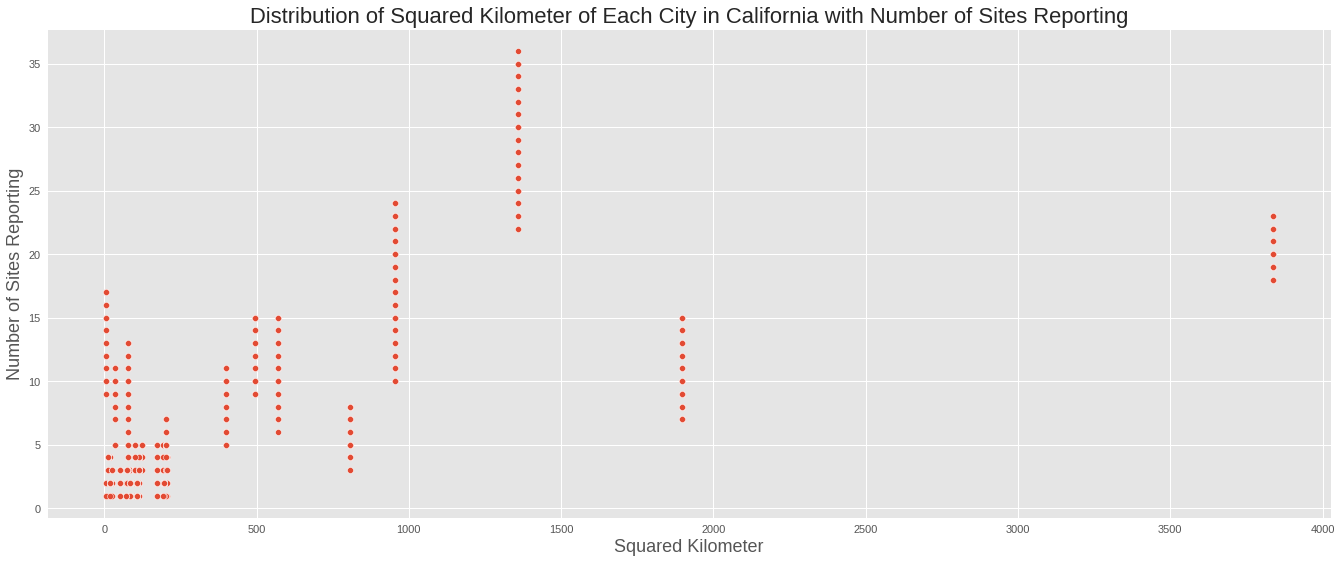

In [ ]:
# plot
fig4 = sns.scatterplot(data=California, x='sq_kilometer (km2)', y='Number of Sites Reporting')
labels('Distribution of Squared Kilometer of Each City in California with Number of Sites Reporting', 'Squared Kilometer', 'Number of Sites Reporting')
plt.savefig('EDA/Q4.png', facecolor=fig4.get_facecolor(), edgecolor='none', dpi=150)

#### what's the reason behind the increasing in number of testing in last decade ?

In [ ]:
# Filter
start_end = df.groupby('CBSA Code')['Date'].agg(['min', 'max'])

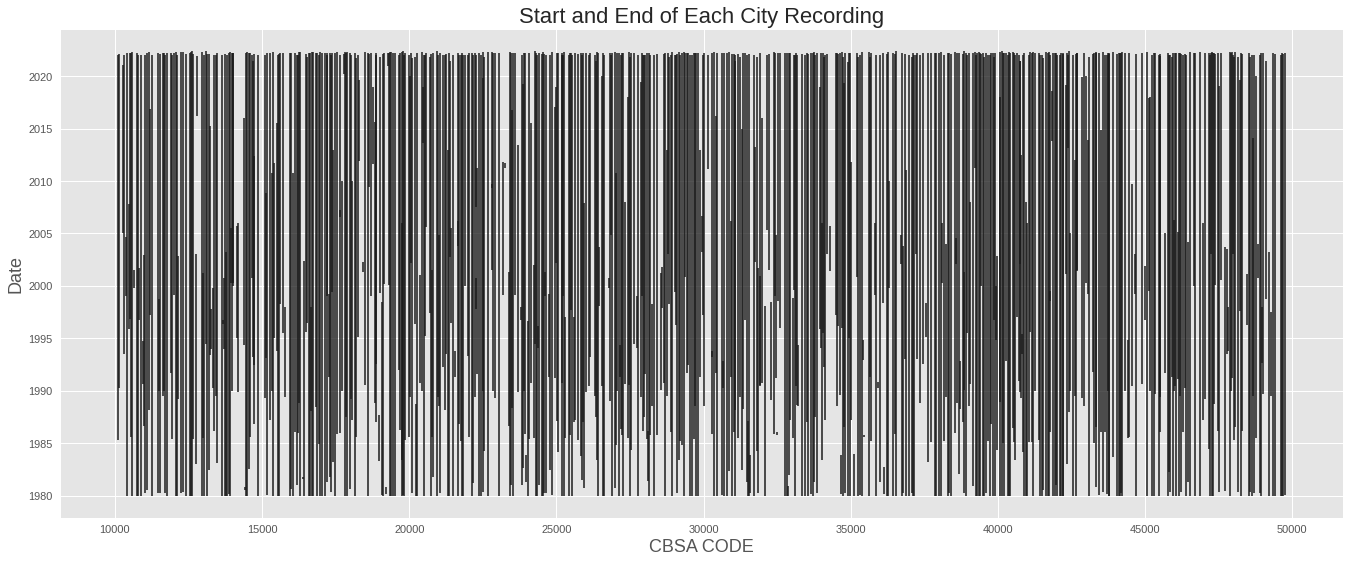

In [ ]:
# plot
plt.vlines(x=start_end.index, ymin=start_end['min'].values, ymax=start_end['max'].values)
labels('Start and End of Each City Recording', 'CBSA CODE', 'Date')
plt.savefig('EDA/Q5.png', facecolor=(0.8980392156862745, 0.8980392156862745, 0.8980392156862745, 1.0), edgecolor='none', dpi=150)

<a id = 'ML'></a>
## Machine Learning Preprocessing, Modeling And Deployment

### Train/Test split

In [13]:
# category dictionary
category_dict = {
    'Good' : 0,
    'Moderate' : 1,
    'Unhealthy for Sensitive Groups' : 2,
    'Unhealthy' : 3,
    'Very Unhealthy' : 4,
    'Hazardous' : 5
} 

In [14]:
# take sample
sample = df[df['Date'] >= '2000-1-1'].copy()

In [15]:
# label encoding
sample.Category = sample.Category.map(category_dict)

In [16]:
# split to feature and target for classification module
x_clf, y_clf = sample.drop('Category', axis=1), sample.Category

In [17]:
# split to feature and target for regression module
x_reg, y_reg = sample.drop('AQI', axis=1), sample.AQI

In [18]:
# train / test split for clf
x_train_clf, x_test_clf, y_train_clf, y_test_clf = train_test_split(x_clf, y_clf, test_size=.2, stratify=y_clf, random_state=42)

In [19]:
# train / test split for reg
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=.2, random_state=42)

### Feature Selection

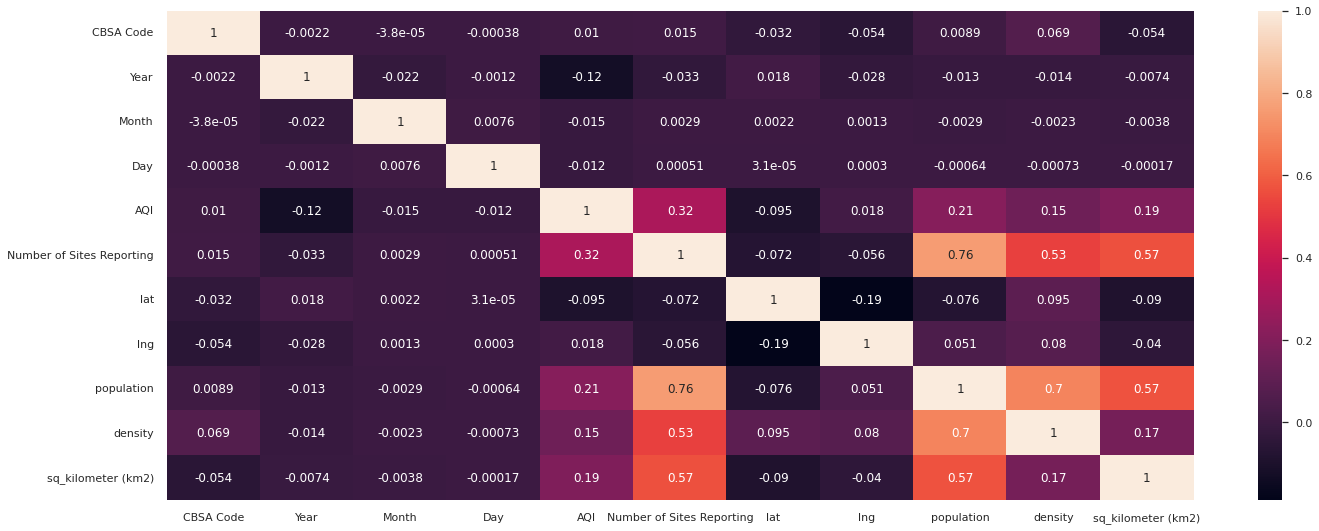

In [55]:
# heatmap for x_train
sns.heatmap(x_train_clf.corr(), annot=True);

In [56]:
# take sample
sample.sample()

,CBSA Code,Date,Year,Month,Day,AQI,Category,Defining Parameter,Number of Sites Reporting,city_ascii,state_name,lat,lng,population,density,sq_kilometer (km2),timezone
2126871,44180,2000-06-04,2000,6,4,58,1,Ozone,4,Springfield,Missouri,37.1943,-93.2916,295230.0,785.0,376.089172,America/Chicago


In [20]:
# drop column for classification module
cols_to_drop = ['Date', 'AQI', 'city_ascii', 'lat', 'lng', 'population', 'sq_kilometer (km2)', 'density']
x_train_clf.drop(cols_to_drop, axis=1 , inplace=True)
x_test_clf.drop(cols_to_drop, axis=1 , inplace=True)

In [21]:
# drop column for regression module
cols_to_drop = ['Date', 'city_ascii', 'lat', 'lng', 'population', 'sq_kilometer (km2)', 'density']
x_train_reg.drop(cols_to_drop, axis=1 , inplace=True)
x_test_reg.drop(cols_to_drop, axis=1 , inplace=True)

### Select Classification Algorithm

#### Create preprocessing Pipeline

In [59]:
# split numerical and categorical columns for pipeline
num_cols_clf = [col for col in x_train_clf.select_dtypes(exclude='object').columns]
cat_cols_clf = [col for col in x_train_clf.select_dtypes(include='object').columns]

In [60]:
# identify numerical and categorical pipeline
num_pipeline_clf = Pipeline(steps=[
                               ('Imputer', SimpleImputer(strategy='median')),
                               ('Scaler', StandardScaler())
                              ])

cat_pipeline_clf = Pipeline(steps=[
                                ('Imputer', SimpleImputer(strategy='most_frequent')),
                                ('OHE', OneHotEncoder(sparse=False)),
                                ('Scaler', StandardScaler())
                              ])

In [61]:
# preprocessing pipeline
preprocessor_clf = ColumnTransformer([('num', num_pipeline_clf, num_cols_clf), ('cat', cat_pipeline_clf, cat_cols_clf)])

#### Analysis and Compare Algorithms with Hyperparameter Tuning

In [65]:
# apply pipelines on x_train_clf and x_test_clf
x_train_clf_pre = preprocessor_clf.fit_transform(x_train_clf)
x_test_clf_pre = preprocessor_clf.transform(x_test_clf)

In [55]:
# some algorithms to compare best accuracy, f1-score
clf_algorithms = {
    'Logistic Regression' : LogisticRegression(multi_class="auto"),
    'KNeighbors' : KNeighborsClassifier(),
    'Naive Bayes' : GaussianNB(),
    'Decision Tree' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'XGBoost' : XGBClassifier(objective='multi:softprob', num_class=6, use_label_encoder=False)
}

In [56]:
# dataframe for result
columns = ['precision (0)', 'recall (0)', 'f1-score (0)',
           'precision (1)', 'recall (1)', 'f1-score (1)',
           'precision (2)', 'recall (2)', 'f1-score (2)',
           'precision (3)', 'recall (3)', 'f1-score (3)',
           'precision (4)', 'recall (4)', 'f1-score (4)',
           'precision (5)', 'recall (5)', 'f1-score (5)',
           'accuracy']
classification = pd.DataFrame( columns=columns)

In [33]:
# for loop to fit all algorthims and return classification report
for name, algorithm in clf_algorithms.items():

  algorithm.fit(x_train_clf_pre, y_train_clf)
  predict = algorithm.predict(x_test_clf_pre)
  Report = classification_report(y_test_clf, predict, output_dict=True)

  row = np.array([])
  for key, value in Report.items():
    if key == '0':
      row = np.append(row, [value['precision'], value['recall'], value['f1-score']])
    elif key == '1':
      row = np.append(row, [value['precision'], value['recall'], value['f1-score']])
    elif key == '2':
      row = np.append(row, [value['precision'], value['recall'], value['f1-score']])
    elif key == '3':
      row = np.append(row, [value['precision'], value['recall'], value['f1-score']])
    elif key == '4':
      row = np.append(row, [value['precision'], value['recall'], value['f1-score']])
    elif key == '5':
      row = np.append(row, [value['precision'], value['recall'], value['f1-score']])
    elif key == 'accuracy':
      row = np.append(row, value)

  classification.loc[name] = row.astype('float')

In [ ]:
# after choose best algorithm apply hyperparameter tuning with cross vals to optimize evaluation of the algorithm
# !note this process consuming alot of time and material
weights = compute_sample_weight(class_weight='balanced', y=y_train_clf)
params = {'n_estimators': [5,20,50,100],
          'max_features': ['auto', 'sqrt'],
          'max_depth': [10, 20, 30 ,40, 50, 90],
          'min_samples_split': [2, 6, 10],
          'min_samples_leaf': [1, 3, 4],
          'bootstrap': [True, False]}

kford = KFold(n_splits=3, shuffle=True, random_state=0)
xg = RandomForestClassifier(n_jobs=-1)
search = HalvingGridSearchCV(xg, params, cv = kford, n_jobs=-1, verbose=10, scoring='f1')
search.fit(x_train_clf_pre, y_train_clf, sample_weight = weights)
print(search.best_params_)

In [83]:
# after choose best algorithm apply hyperparameter tuning with cross vals to optimize evaluation of the algorithm
# !note this process consuming alot of time and material
weights = compute_sample_weight(class_weight='balanced', y=y_train_clf)
params = {'learning_rate': [0.01,0.1,0.2,0.5, 1],
          'min_child_weight': [1,2,3,4],
          'sampling_method' : ['uniform', 'subsample', 'gradient_based'],
          'max_delta_step' : [0, 1, 2],
          'alpha' : [2,3,4],
          'gamma' : [1,2,3,4]}

kford = KFold(n_splits=3, shuffle=True, random_state=0)
xg = XGBClassifier(n_jobs=-1, objective='multi:softprob', tree_method = 'hist', scale_pos_weight= 10000, eval_metric= 'mlogloss', max_depth=26)
search = HalvingGridSearchCV(xg, params, cv = kford, n_jobs=-1, verbose=10, scoring='f1')
search.fit(x_train_clf_pre, y_train_clf, sample_weight = weights)
print(search.best_params_)

#### Evaluate The Algorithm

In [62]:
xg_clf = XGBClassifier(n_jobs=-1, max_depth=30, max_delta_step=1, min_child_weight = 1, learning_rate = 0.2, alpha = 2, gamma = 2,
                       objective='multi:softprob', tree_method = 'hist', scale_pos_weight= 10000, eval_metric= 'mlogloss')

In [63]:
# create weight on y_train
weights = compute_sample_weight(class_weight='balanced', y=y_train_clf)

In [66]:
# fit final model
xg_clf.fit(x_train_clf_pre, y_train_clf, sample_weight=weights)

XGBClassifier(alpha=2, eval_metric='mlogloss', gamma=2, learning_rate=0.2,
              max_delta_step=1, max_depth=30, n_jobs=-1,
              objective='multi:softprob', scale_pos_weight=10000,
              tree_method='hist')

In [67]:
# check of overfitting or underfitting
print(f'score on train: {xg_clf.score(x_train_clf_pre, y_train_clf)}')
print(f'score on test: {xg_clf.score(x_test_clf_pre, y_test_clf)}')

score on train: 0.8350990869100281
score on test: 0.7831262983727532


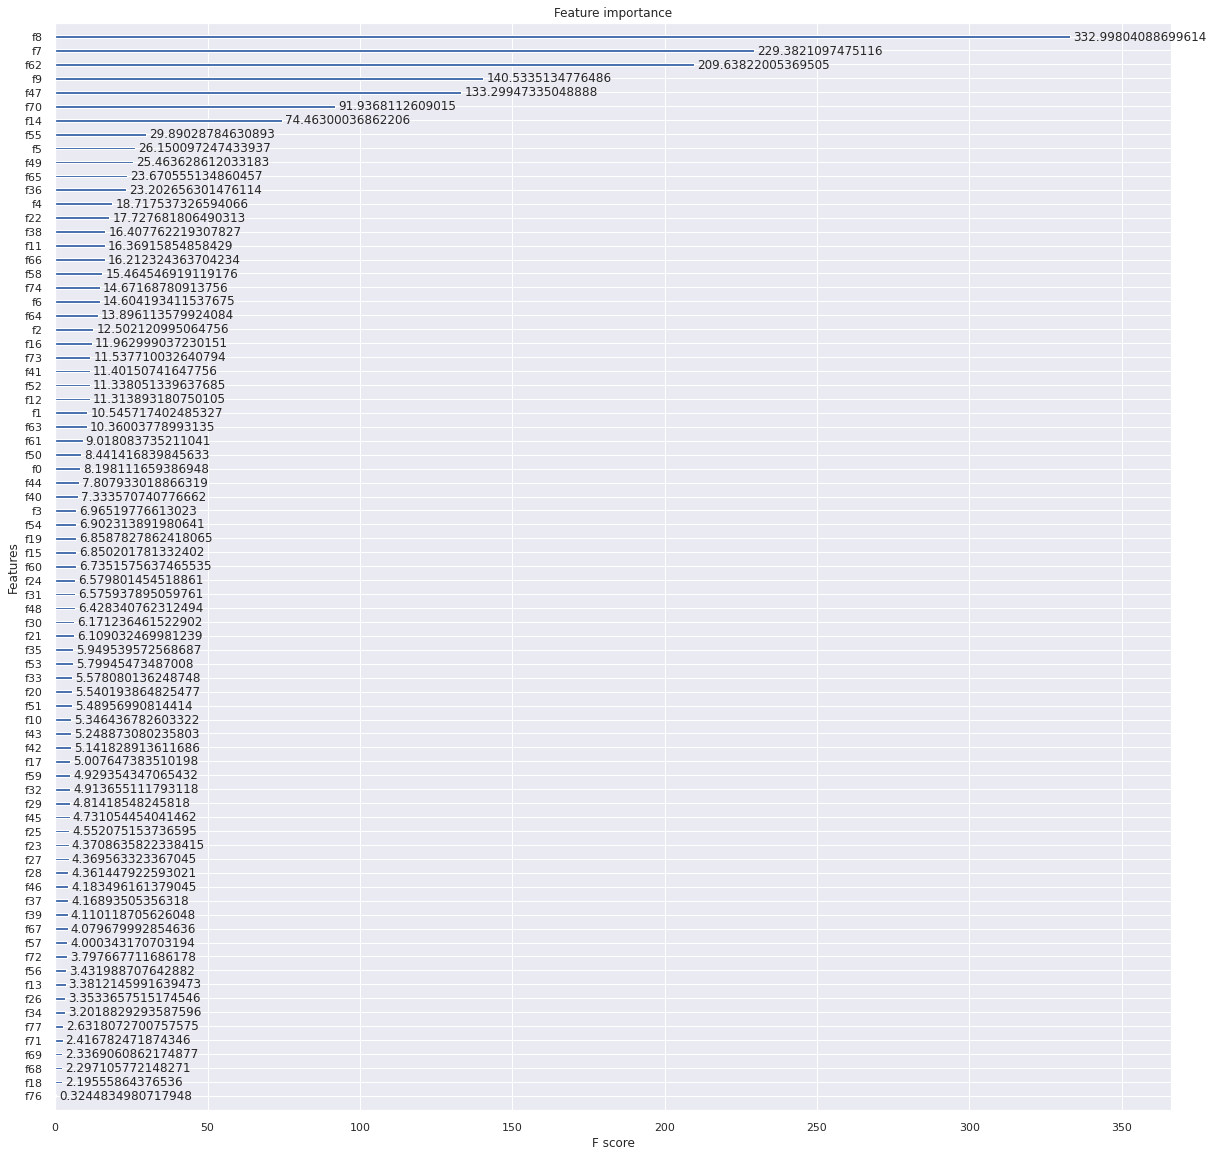

In [84]:
# check features importance
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_importance(xg_clf, importance_type='gain');

In [68]:
# prediction on test label
clf_preds = xg_clf.predict(x_test_clf_pre)

In [69]:
# print confusion matrix
confusion_matrix(y_test_clf, clf_preds)

array([[404353,  90270,   6422,    671,     67,     28],
       [ 26528, 138556,  16447,   1544,    123,     42],
       [   438,   6299,  10794,   1826,    130,     16],
       [    39,    450,   1855,   1782,    245,     16],
       [     5,     28,     94,    226,    160,     15],
       [     2,     17,     15,     12,     11,     16]])

In [70]:
# print classification report
print(classification_report(y_test_clf, clf_preds))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87    501811
           1       0.59      0.76      0.66    183240
           2       0.30      0.55      0.39     19503
           3       0.29      0.41      0.34      4387
           4       0.22      0.30      0.25       528
           5       0.12      0.22      0.16        73

    accuracy                           0.78    709542
   macro avg       0.41      0.51      0.44    709542
weighted avg       0.83      0.78      0.80    709542



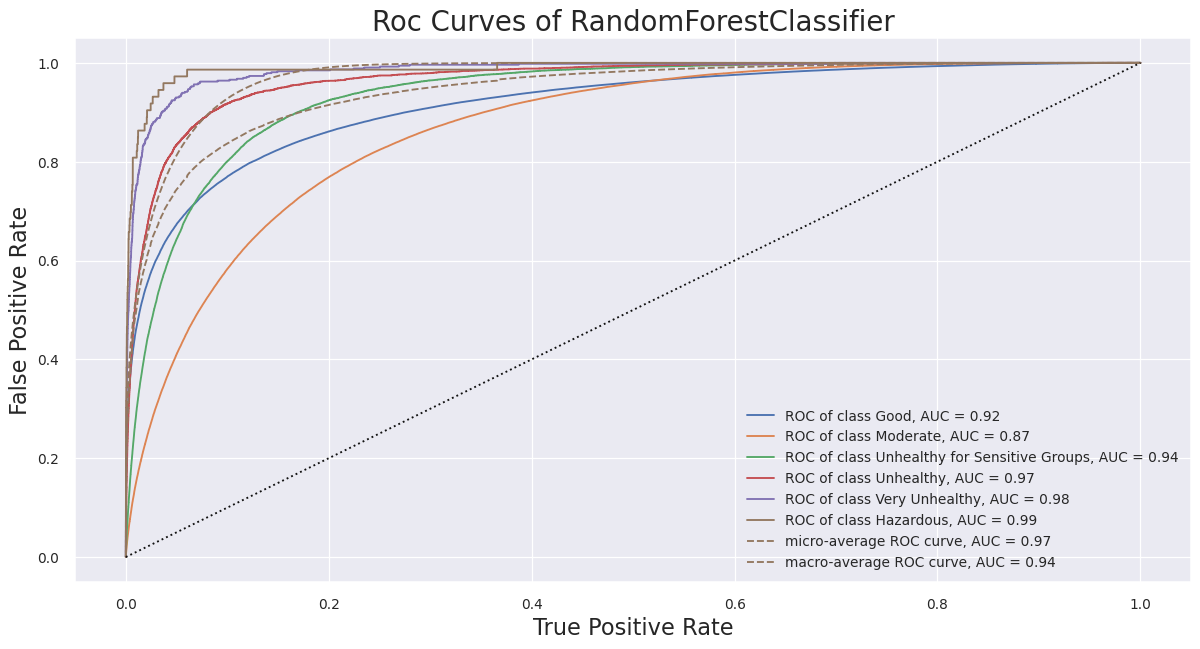

In [71]:
# plot Roc Curves of Xgboostclassifier
visualizer = ROCAUC(xg_clf, classes=["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous"]) # take instance

plt.figure(figsize=(16, 8), dpi=90)
visualizer.fit(x_train_clf_pre, y_train_clf)
visualizer.score(x_test_clf_pre, y_test_clf)
plt.legend()
labels('Roc Curves of RandomForestClassifier', 'True Positive Rate', 'False Positive Rate')
plt.savefig('EDA/ROC curve.png', edgecolor='none', dpi=150)

#### Final Classification pipeline

In [70]:
# final pipeline
classification_pipeline = Pipeline([('preprocess', preprocessor_clf), ('model', xg_clf)])
classification_pipeline.fit(x_train_clf, y_train_clf)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['CBSA Code', 'Year', 'Month',
                                                   'Day',
                                                   'Number of Sites '
                                                   'Reporting']),
                                                 ('cat',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                

In [71]:
# save model
save_clf = joblib.dump(classification_pipeline, '/content/classification_model.pkl')

### Select Regression Algorithm

#### Create Pipeline

In [22]:
# split numerical and categorical columns for pipeline
num_cols_reg = [col for col in x_train_reg.select_dtypes(exclude='object').columns]
cat_cols_reg = [col for col in x_train_reg.select_dtypes(include='object').columns]

In [23]:
# identify numerical and categorical pipeline
num_pipeline_reg = Pipeline(steps=[
                               ('Imputer', SimpleImputer(strategy='median')),
                               ('Scaler', StandardScaler())
                              ])

cat_pipeline_reg = Pipeline(steps=[
                                ('Imputer', SimpleImputer(strategy='most_frequent')),
                                ('OHE', OneHotEncoder(sparse=False)),
                                ('Scaler', StandardScaler())
                              ])

In [24]:
# preprocessing pipeline
preprocessor_reg = ColumnTransformer([('num', num_pipeline_reg, num_cols_reg), ('cat', cat_pipeline_reg, cat_cols_reg)])

#### Analysis and Compare Algorithms with Hyperparameter Tuning

In [25]:
# apply pipelines on x_train_reg and x_test_reg
x_train_reg_pre = preprocessor_reg.fit_transform(x_train_reg)
x_test_reg_pre = preprocessor_reg.transform(x_test_reg)

In [ ]:
# some algorithms to compare best accuracy, RMSE
reg_algorithms = {
    'Linear Regression' : LinearRegression(),
    'Lasso' : Lasso(),
    'Ridge' : Ridge(),
    'XGBoost' : XGBRFRegressor()
}

In [ ]:
# dataframe for result
columns = ['train_score', 'test_score', 'RMSE']
regression = pd.DataFrame( columns=columns)

In [ ]:
# for loop to fit all algorthims and return train/test score and RMSE
for name, algorithm in reg_algorithms.items():

  algorithm.fit(x_train_reg_pre, y_train_reg)
  row = np.array([])

  predict = algorithm.predict(x_test_reg_pre)
  train_score = algorithm.score(x_train_reg_pre, y_train_reg)
  test_score = algorithm.score(x_test_reg_pre, y_test_reg)
  RMSE = np.sqrt(mean_squared_error(y_test_reg, predict))

  row = np.append(row, [train_score, test_score, RMSE])
  regression.loc[name] = row

In [ ]:
params = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 1],
        'max_depth': [40, 50, 55, 60],
        'min_child_weight': [1, 2, 3],
        'colsample_bytree' : [0.4, 0.6, 0.8, 1]
    }

kford = KFold(n_splits=3, shuffle=True, random_state=0)
xg = XGBRFRegressor(n_jobs=-1, objective='reg:squarederror')
search = HalvingGridSearchCV(xg, params, cv = kford, n_jobs=-1, verbose=10, scoring='r2')
search.fit(x_train_reg_pre, y_train_reg)
print(search.best_params_)

#### Evaluate The Algorithm

In [26]:
# best algorithm with optimum parameters
xg_reg = XGBRFRegressor(n_jobs=-1, objective='reg:squarederror', learning_rate=1, max_depth=40, min_child_weight=1)

In [27]:
# fit model
xg_reg.fit(x_train_reg_pre, y_train_reg)

XGBRFRegressor(max_depth=40, n_jobs=-1, objective='reg:squarederror')

In [28]:
# check of overfitting or underfitting
print(f'score on train: {xg_reg.score(x_train_reg_pre, y_train_reg)}')
print(f'score on test: {xg_reg.score(x_test_reg_pre, y_test_reg)}')

score on train: 0.8733815038229877
score on test: 0.8691255323465228


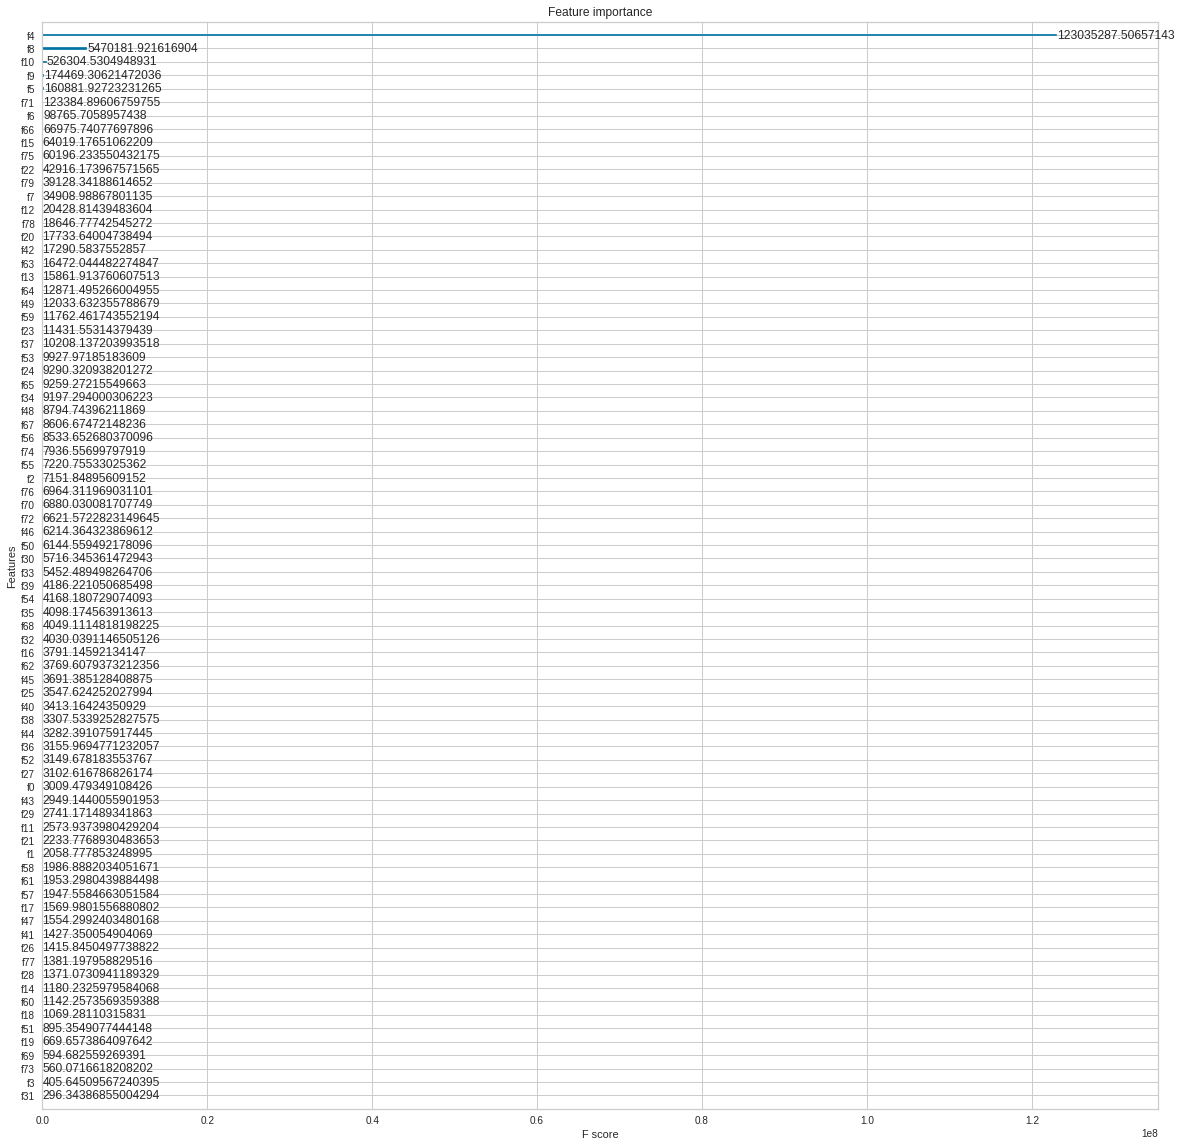

In [29]:
# check features importance
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_importance(xg_reg, importance_type='gain');

In [30]:
# predict
reg_preds = xg_reg.predict(x_test_reg_pre)

In [31]:
# mean absolute error evaluation
print("MAE:",mean_absolute_error(y_test_reg,reg_preds))

MAE: 6.951325059799504


In [32]:
# root mean square error evaluation
print("RMSE:",np.sqrt(mean_squared_error(y_test_reg,reg_preds)))

RMSE: 9.007823410509348


In [33]:
# R square evaluation
print("R2:",r2_score(y_test_reg,reg_preds))

R2: 0.8691255323465228


#### Final Regression pipeline

In [34]:
regression_pipeline = Pipeline([('preprocess', preprocessor_reg), ('regression_model', xg_reg)])
regression_pipeline.fit(x_train_reg, y_train_reg)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['CBSA Code', 'Year', 'Month',
                                                   'Day', 'Category',
                                                   'Number of Sites '
                                                   'Reporting']),
                                                 ('cat',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                    

In [35]:
save_reg = joblib.dump(regression_pipeline, '/content/regression_model.pkl')

### Deployment

In [37]:
# kill path
ngrok.kill()

In [38]:
# create authentication token key
ngrok_auth_token = "2EGcm41v7IsiF6fGAnzkrg9SbCV_4244zMLbeqpPEUUxZ2CRr"
ngrok.set_auth_token(ngrok_auth_token)

In [39]:
%%writefile app.py
import numpy as np
import pandas as pd
import streamlit as st
import joblib

classification_model = joblib.load('/content/classification_model.pkl')
regression_model = joblib.load('/content/regression_model.pkl')

def welcome():
    return "Welcome All"

def predict_AQI (CBSA_Code, Year, Month, Day, Defining_Parameter, Number_of_Sites_Reporting, state_name, timezone):

  category_prediction = classification_model.predict(pd.DataFrame({'CBSA Code':[CBSA_Code],'Year':[Year], 'Month':[Month], 'Day':[Day], 'Defining Parameter':[Defining_Parameter],
                                                                     'Number of Sites Reporting':[Number_of_Sites_Reporting], 'state_name':[state_name], 'timezone': [timezone]}
                                                                     ))

  AQI_prediction = regression_model.predict(pd.DataFrame({'CBSA Code':[CBSA_Code],'Year':[Year], 'Month':[Month], 'Day':[Day],'Category' : [category_prediction], 'Defining Parameter':[Defining_Parameter],
                                                                     'Number of Sites Reporting':[Number_of_Sites_Reporting], 'state_name':[state_name], 'timezone': [timezone]}
                                                                     ))
  return int(AQI_prediction)

def main():
    st.title("Air Quality Index Prediction")
    html_temp = """
    <div style ="background-color:tomato;padding;10px">
    <h2 stylr = "color:white;text-align:center;">streamlit AQI ML App</h2>
    </div>
    """
    st.markdown(html_temp,unsafe_allow_html =True)

    if st.button ("Note!"):
        st.text("For best prediction, please select right state with timezone that match CBSA code")
        
    state_name_option = ['North Carolina', 'Wisconsin', 'Colorado', 'North Dakota', 'Alabama', 'New York', 'Pennsylvania', 'Washington', 'West Virginia', 'Ohio', 'South Carolina', 'Arkansas', 'Illinois',
       'Oregon', 'Kansas', 'Iowa', 'Maine', 'Tennessee', 'Idaho', 'Indiana', 'Oklahoma', 'Florida', 'Montana', 'Arizona', 'Nebraska', 'District of Columbia', 'Alaska', 'California', 'Utah',
       'Louisiana', 'Georgia', 'New Hampshire', 'Rhode Island', 'Hawaii', 'Missouri', 'New Jersey', 'Mississippi', 'Massachusetts', 'Wyoming', 'Michigan', 'Kentucky', 'New Mexico', 'Delaware',
       'Puerto Rico', 'Vermont', 'Connecticut', 'Texas', 'Minnesota', 'Virginia', 'South Dakota', 'Maryland', 'Nevada']
    state_name = st.selectbox("state name",options = state_name_option)

    CBSA_Code = st.text_input("CBSA Code","CBSA Code of Usa City")

    datetime = st.date_input("Date")

    Defining_Parameter_option = ['PM2.5', 'Ozone', 'CO', 'PM10', 'NO2']
    Defining_Parameter = st.selectbox("Defining Parameter",options = Defining_Parameter_option)

    Number_of_Sites_Reporting = st.text_input("Number of Sites Reporting")

    timezone_option = ['America/New_York', 'America/Chicago', 'America/Denver', 'America/Los_Angeles', 'America/Boise', 'America/Phoenix', 'America/Anchorage',
                       'America/Sitka', 'Pacific/Honolulu', 'America/Indiana/Indianapolis', 'America/Detroit', 'America/Puerto_Rico', 'America/Indiana/Vincennes',
                       'America/Juneau', 'America/Matamoros', 'America/Toronto', 'America/Menominee']
    timezone = st.selectbox("timezone",options = timezone_option)

    result = ""
    if st.button("predict"):
        result= predict_AQI (CBSA_Code, datetime.year, datetime.month, datetime.day, Defining_Parameter, Number_of_Sites_Reporting, state_name, timezone)
    st.success("AQI almost will be {}".format(result))
        
if __name__=='__main__':
    main()

Overwriting app.py


In [40]:
# create new tunnel
ngrok.connect(8501)

<NgrokTunnel: "http://a689-35-192-148-138.ngrok.io" -> "http://localhost:8501">

In [41]:
# run app
!streamlit run app.py

2022-09-09 08:14:28.910 INFO    numexpr.utils: Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-09-09 08:14:28.910 INFO    numexpr.utils: NumExpr defaulting to 8 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.192.148.138:8501

tcmalloc: large alloc 1621565440 bytes == 0x4706000 @  0x7f6e807081e7 0x4a3940 0x5b438c 0x5d0ccd 0x59358d 0x548c51 0x51566f 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x593dd7 0x511e2c 0x549576 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x604173 0x62a809 0x59358d 0x515244 0x549e0e 0x593fce 0x511e2c 0x4bc98a 0x59c019
tcmalloc: large alloc 1621565440 bytes == 0x65178000 @  0x7f6e807081e7 0x4a3940 0x59b5e2 0x59e7bb 0x53786a 0x595ef6 0x5134a6 0x593dd7 0x5118f8 0x593dd7 0x511e2c 0x549576 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x604173 0x62a809 0x59358d 0x515244 0x549e0e 0x593fce 0x511e2c 0

<a id = 'Conclusion'></a>
# Conclusion

* **Some tests show a defect in the measurements, perhaps as a result of abnormal things that led to a defect during the tests.**
---
*   **The most important factor affecting (AQI) is the damage caused by the ozone, but it is less dangerous compared to the rest of the elements.**
---
*   **Successful model to predict (AQI) but in my opinion (AQI) value its very important and missing one can be cause a lot of problems so predict on location and datetime not enough to achieve the purpose, but the model can be powerful and accurate if additional data added such as weather details, air and industrial pollution information.**


